In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats,integrate
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


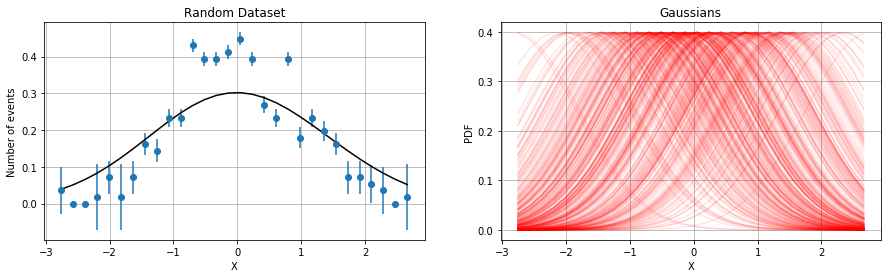

In [6]:
#normally distributed variable; mean=0, std=1, size=300
np.random.seed(2012266)
x=np.random.normal(loc=0,scale=1,size=300)

#make an histogram with proper aestethic
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

bins=30 #number of bins
counts,bin_edges = np.histogram(x,bins)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = 5/(integrate.trapz(counts,bin_centres)*np.sqrt(counts)) #error multiplied by factor 5

#plot histograms of original variables
ax1.title.set_text("Random Dataset")
ax1.errorbar(bin_centres, counts/integrate.trapz(counts,bin_centres), yerr=err, fmt='o') #NORMALIZED TO 1
ax1.set_ylabel("Number of events") 
ax1.set_xlabel("X")
ax1.grid()
ax1.set_yticks(np.arange(0,0.5,0.1))


#create a gaussian for every mean=x[i]
Y=np.zeros((300,bins))

for i in range(300):
    Y[i]=stats.norm.pdf(bin_centres,loc=x[i]) #create a gaussian
    Y[i]=Y[i]
    ax2.plot(bin_centres,Y[i],color='red',alpha=0.1) #plot all of them
    
ax2.grid()
ax2.set_yticks(np.arange(0,0.5,0.1))
ax2.set_title("Gaussians")
ax2.set_xlabel("X")
ax2.set_ylabel("PDF")
ax1.plot(bin_centres,np.sum(Y,axis=0)/integrate.trapz(np.sum(Y,axis=0),bin_centres),color='black')

plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

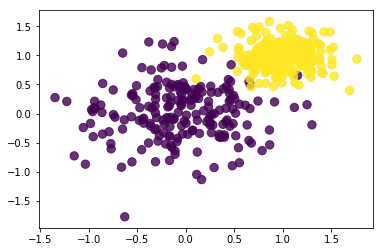

In [3]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('Data/two_categories_scatter_plot.png')

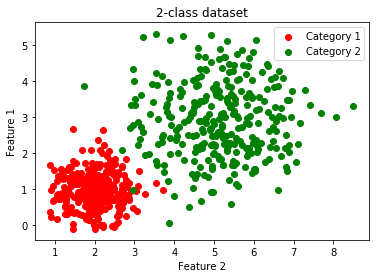

In [4]:
plt.figure(1)

#first cluster
x1=np.random.normal(1,0.5,300)
y1=np.random.normal(2,0.5,300)

#second cluster
x2=np.random.normal(3,1,300)
y2=np.random.normal(5,1,300)

#plot
plt.scatter(y1,x1,color='red')
plt.scatter(y2,x2,color='green')
plt.title("2-class dataset")
plt.ylabel("Feature 1")
plt.xlabel("Feature 2")
plt.legend(['Category 1','Category 2'])
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

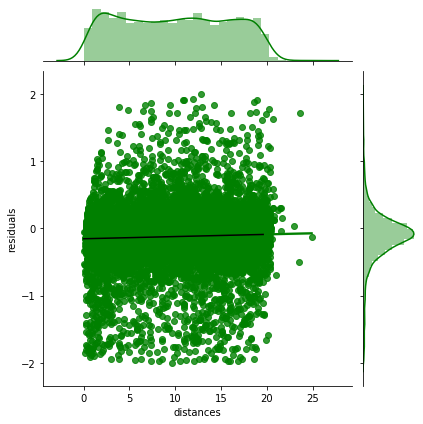

In [5]:
#load the data
filename="Data/residuals_261.npy"
x=np.load("Data/residuals_261.npy",allow_pickle=True) #allow_pickle?
df=pd.DataFrame(x.item())

#clean the sample with |residual|<2
df=df[df['residuals']<2]
df=df[df['residuals']>-2]
df

#perform a linear regression of residuals vs distance
slope,intercept,rvalue,pvalue,stderr=stats.linregress(df['distances'],df['residuals'])
def lin(x):
    return slope*x + intercept

#seaborn jointplot
sns.jointplot(x="distances", y="residuals", data=df, kind="reg",color='green')

#fill 3 np arrays
x=np.arange(0,20,0.4) #bin centres
y=lin(x) #mean values of "residuals" estimated in slices of "distance"
erry=np.std(y) #y standard deviation

#plot profile plot
plt.plot(x,y,scaley=erry,color='black')